In [2]:
# 사용하는 라이브러리 다 불러오기
import pandas as pd
from geopy.geocoders import Nominatim
import re
import numpy as np
import matplotlib.pyplot as plt
import folium

In [1]:
import pandas as pd

#데이터 불러오기
original_data = pd.read_csv("data.csv", encoding='cp949')
data = original_data

### 1. 데이터 확인

In [2]:
data.head()

,도서관명,시도명,시군구명,도서관유형,휴관일,평일운영시작시각,평일운영종료시각,토요일운영시작시각,토요일운영종료시각,공휴일운영시작시각,...,운영기관명,도서관전화번호,부지면적,건물면적,홈페이지주소,위도,경도,데이터기준일자,제공기관코드,제공기관명
0,이석영뉴미디어도서관,경기도,남양주시,공공도서관,둘째·넷째 금요일+1월 1일+설날·추석 연휴(대체공휴일 포함),9:00,22:00,9:00,18:00,9:00,...,사단법인 문화현상,031-595-8390,1843.0,4877.0,http://lib.nyj.go.kr/lsy,37.658160,127.299532,2023-04-30,3990000,경기도 남양주시
1,원덕도서관,강원도,삼척시,공공도서관,토요일+일요일+법정공휴일,9:00,18:00,0:00,0:00,0:00,...,강원도 삼척시청,033-572-4819,766.0,364.0,NaN,37.176854,129.335484,2023-06-20,4241000,강원특별자치도 삼척시
2,가평군 한석봉도서관,경기도,가평군,공공도서관,1월 1일+설 연휴+추석연휴,7:00,23:59,7:00,23:59,7:00,...,경기도 가평군,031-580-4041,7485.0,3602.0,www.gaplib.go.kr,37.829691,127.506433,2023-06-21,4160000,경기도 가평군
3,가평군 설악도서관,경기도,가평군,공공도서관,1월 1일+설 연휴+추석연휴,7:00,23:59,7:00,23:59,7:00,...,경기도 가평군,031-580-4313,3693.0,1470.0,www.gaplib.go.kr,37.683315,127.491015,2023-06-21,4160000,경기도 가평군
4,가평군 청평도서관,경기도,가평군,공공도서관,1월 1일+설 연휴+추석연휴,7:00,23:59,7:00,23:59,7:00,...,경기도 가평군,031-580-4332,4500.0,2486.0,www.gaplib.go.kr,37.739591,127.424230,2023-06-21,4160000,경기도 가평군


In [3]:
#NaN값 확인 - 위도, 경도가 없는 경우가 많음 -> 소재지 도로명 주소는 있음
data.isnull().sum()

도서관명             0
시도명              0
시군구명             0
도서관유형            0
휴관일              0
평일운영시작시각         0
평일운영종료시각         0
토요일운영시작시각        0
토요일운영종료시각        0
공휴일운영시작시각        0
공휴일운영종료시각        0
열람좌석수            0
자료수(도서)          0
자료수(연속간행물)       0
자료수(비도서)         0
대출가능권수           0
대출가능일수           0
소재지도로명주소         0
운영기관명          668
도서관전화번호        233
부지면적          1610
건물면적           481
홈페이지주소        1422
위도             258
경도             247
데이터기준일자          0
제공기관코드           0
제공기관명            0
dtype: int64

In [4]:
data1 = data.loc[:, ['도서관명', '소재지도로명주소', '위도', '경도']]

In [5]:
# 위도, 경도를 도로명주소로 찾아서 변환
# 위도나 경도가 NaN인 값을 찾아서 데이터프레임 출력
nan_df = data1[data['위도'].isnull() | data['경도'].isnull()]

print(nan_df.count())  # 258

nan_df.head()

도서관명        258
소재지도로명주소    258
위도            0
경도           11
dtype: int64


,도서관명,소재지도로명주소,위도,경도
45,사천시어린이도서관,경상남도 사천시 사남면 조동길 49-30,NaN,NaN
78,맑은숲작은도서관,울산광역시 동구 명덕6길 29,NaN,NaN
161,크레파스작은도서관,울산광역시 동구 동해안로 98,NaN,NaN
262,손기정문화도서관,서울특별시 중구 손기정로101,NaN,NaN
263,장충동 작은도서관,서울특별시 중구 동호로25길 33,NaN,NaN


### 2. 전처리

#### 2-1. 결측치 처리 - 위경도가 없는 데이터 채워주기

In [6]:
# 위경도 변환하기 위한 라이브러리 설치
!pip install geopy

In [7]:
# 위경도 변환 라이브러리 불러오기
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="library_map")

##### 2-1-1. 위경도 찾기 위해 주소 가공 - 정규표현식 사용

In [8]:
# 정규표현식 사용 - 위경도 찾기 위한 주소 가공
import re

'''
1. 괄호와 괄호 뒷부분 다 지우기        / (지족동) -> ""
2. '(숫자)번길', '(숫자)길' 앞에 띄어쓰기를 지운다.       / 수레로 1260번길 -> 수레로1260번길
3. 번길 뒤에 숫자가 있을 경우 띄어쓰기를 한다.  / 1260번길33 -> 1260번길 33
4. 쉼표(,)와 쉼표 뒷부분 다 지우기
5. (숫자)층, (숫자)동 붙은거 뒷부분은 다 지우기
6. 아파트, 복지관이 붙은 단어와 단어의 뒷부분 지우기
7. 숫자 앞에 띄어쓰기 없으면 하기   / 대학길40-1 -> 대학길 40-1
8. 앞뒤에 strip()함수 써서 띄어쓰기 제거하기


'''

def address_process(text):


    # 1. 괄호와 괄호 뒷부분 다 지우기
    round = re.search('\(.*\).*', text)
    if round:
        round = round.group()
        text = re.sub('\(.*\).*', '', text)


    # 2. '(숫자)번길', '(숫자)길' 앞에 띄어쓰기를 지운다.
    road = re.search('\s*\d+번길|\s*\d+길', text)
    if road:
        road = road.group().strip()
        text = re.sub('\s*\d+번길|\s*\d+길', road, text)  # 경기도 남양주시 화도읍 수레로1260번길33


    # 3. '번길', '길' 뒤에 숫자가 있을 경우 띄어쓰기를 한다.
    num = re.search('\d+번길\d+|\d+길\d+', text)
    if num:
        num = num.group()
        num = re.search('\d+$', num).group()


    # 4. 쉼표(,)와 쉼표 뒷부분 다 지우기
    text = re.sub(',.*', '', text)


    # 5. (숫자)층, (숫자)동 붙은거 뒷부분은 다 지우기
    text = re.sub('\d+동.*', '', text)
    text = re.sub('\d+층.*', '', text)


    # 6. 아파트, 복지관이 붙은 단어와 단어의 뒷부분 지우기
    text = re.sub('\s+[\w가-힣]*아파트.*', '', text)
    text = re.sub('\s+[\w가-힣]*복지관.*', '', text)

    # 7. 숫자 앞에 띄어쓰기 없으면 하기
    # 숫자 앞에 번길이 없는 경우에만 할 것
    # s*\d+-*\d+ 숫자는 40-1 과 401 둘다 찾는다.
    if not num and not road:
        num_space = re.search('\s*\d+-*\d+$', text)
        if num_space:
            num_space = num_space.group().strip()
            text = re.sub('\s*\d+-*\d+$',' '+ num_space, text)


    road_num_regexp = '\d+번길\d+|\d+길\d+'

    if road and num:
        result = re.sub(road_num_regexp, road+" "+num, text)  # 경기도 남양주시 화도읍 수레로 1260번길 33
    #elif road:
    #    result = re.sub(road_num_regexp, road, text)
    elif num:
        result = re.sub(road_num_regexp, num, text)
    else:
        result = text

    #print(result)

    #7. 앞뒤에 strip()함수 써서 띄어쓰기 제거하기
    result = result.strip()

    return result

In [9]:
# address_process 함수 테스트
text = "서울특별시 강남구 남부순환로 378길 34-9(도곡2문화센터 1층)도곡동 518-8"
#text = "경기도 남양주시 화도읍 수레로 1260번길 33"
address_process(text)

'서울특별시 강남구 남부순환로378길 34-9'

In [74]:
# 위경도 변환 샘플 예제
location = geolocator.geocode("은평구 진관4로 48-51")
print(location)
if location:
    print(location.latitude)
    print(location.longitude)

    print((location.latitude, location.longitude))

진관4로, 진관동, 은평구, 서울, 03303, 대한민국
37.6453791
126.9269472
(37.6453791, 126.9269472)


In [12]:
# 위경도 변환 함수
def coord(address):

    result = ""
    location = geolocator.geocode(address)

    if location:
        result = (location.latitude, location.longitude)

    return result

In [13]:
# 테스트를 위하여 위도와 경도가 NaN를 가진
# 데이터들 중에 소재지도로명주소 열만 가져옴
nan_address = nan_df.loc[:,'소재지도로명주소']

In [14]:
# 위경도를 구해서 result_list 리스트에 담음
result_list = []
for e in nan_address:
    address = address_process(e)
    result = coord(address)
    result_list.append(result)

print(result_list)

['', (35.5241701, 129.4317128), (35.5429174, 129.4303354), (37.5552947, 126.963736), (37.5587151, 127.0015589), (37.5498323, 127.0058824), (37.07417, 127.38598), '', '', '', (35.508852700000006, 129.42671760151546), (35.50490275, 129.41665009077644), (35.50316, 129.42927), (35.4984755, 129.4192181), (35.484532, 129.4158766), (35.4909863, 129.41860598893481), (35.52281, 129.42899), (35.5166998, 129.4306185), (35.5434089, 129.4275833), (35.4861154, 129.4157592), (35.4899476, 129.4262602134266), (35.5137825, 129.4289254), '', '', (37.0053735, 127.2593355), '', (37.0079107, 127.1842449), (37.0043472, 127.1703209), (36.9997577, 127.154667), '', (37.6102473, 126.9468443), (35.1831242, 128.1030948), '', (35.7013006, 127.6863483), (35.4807762, 127.6845917), '', '', '', '', '', '', (35.5517421, 127.6368805), '', '', '', (35.275203, 126.506624), (34.4863568, 126.264586), (35.9414261, 128.9001449), '', (34.9634415, 127.7163532), (34.5984306, 127.2766145), (34.947793000000004, 127.69091310095111),

In [15]:
print(len(nan_df))      # 위경도가 없는 데이터 개수
print(len(result_list))
print(result_list.count(''))  # 위경도를 찾지 못한 데이터

258
258
46


In [16]:
# 위경도를 찾은 데이터는 df에 넣기
import numpy as np

result_array = np.array(result_list)  #list타입을 array로 바꿔준다.
not_nan_index = np.where(result_array != "")[0]
#print(index)

#nan가 아닌 데이터의 인덱스 번호 구하기
not_nan_index = nan_df.index[not_nan_index]
#print(not_nan_index)

<ipython-input-16-6ffee9b10914>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result_array = np.array(result_list)  #list타입을 array로 바꿔준다.


In [17]:
# 값이 있는 result_list만 사용
add_coord = [x for x in result_list if x != '']
len(add_coord)

212

##### 2-1-2. 위경도 찾은 것을 original_data에 값 넣어주기

In [18]:
#not_nan_index 번호를 for문 돌리면서 거기에 해당하는 위경도 좌표를 넣어줌
for i in range(len(not_nan_index)):
    index = not_nan_index[i]

    original_data.loc[index, '위도'] = add_coord[i][0]
    original_data.loc[index, '경도'] = add_coord[i][1]

In [19]:
nan_df2 = data1[original_data['위도'].isnull() | original_data['경도'].isnull()]
print(len(nan_df2)) #기존 258 -> 46 로 줄어듬

46


============================

##### 2-1-3. 위의 방법으로 위경도를 찾지 못한 데이터 처리

In [20]:
# result_list에서 비어있는 값을 가진 인덱스 번호 찾기
import numpy as np
result_array = np.array(result_list)  #list타입을 array로 바꿔준다.
nan_index = np.where(result_array == "")[0]
print(nan_index)

[  0   7   8   9  22  23  25  29  32  35  36  37  38  39  40  42  43  44
  48  52  65  69  98 101 105 120 122 123 124 126 127 129 130 131 132 160
 161 162 163 168 185 189 190 221 253 255]


<ipython-input-20-096fb95d882b>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result_array = np.array(result_list)  #list타입을 array로 바꿔준다.


In [21]:
print(len(nan_index))  #97

46


In [22]:
nan_index

array([  0,   7,   8,   9,  22,  23,  25,  29,  32,  35,  36,  37,  38,
        39,  40,  42,  43,  44,  48,  52,  65,  69,  98, 101, 105, 120,
       122, 123, 124, 126, 127, 129, 130, 131, 132, 160, 161, 162, 163,
       168, 185, 189, 190, 221, 253, 255])

In [23]:
# 위경도가 nan 값인 것 찾기
#nan_df2  # 97
#nan_data = original_data.loc[nan_index] # 97

In [91]:
import pandas as pd
nan_df2.to_excel('nan_data.xlsx') #nan 데이터 엑셀로 확인

In [96]:
# 수작업한 엑셀파일 불러오기
fill_data = pd.read_excel('nan_data_fill.xlsx')


In [97]:
fill_data.head()

,index,도서관명,소재지도로명주소,위도,경도
0,45,사천시어린이도서관,경상남도 사천시 사남면 조동길 49-30,35.059331,128.006368
1,341,대림동산작은도서관,경기도 안성시 공도읍 대림동산길 38,37.013983,127.203149
2,342,양성작은도서관,경기도 안성시 양성면 읍내길 21,37.059868,127.194685
3,343,미양작은도서관,경기도 안성시 미양면 양지길 29,36.975403,127.215281
4,398,안성시 진사도서관,경기도 안성시 공도읍 진사2길 70,36.993408,127.145408


In [99]:
fill_data = fill_data.set_index(keys='index')
fill_data.head()

,도서관명,소재지도로명주소,위도,경도
index,,,,
45,사천시어린이도서관,경상남도 사천시 사남면 조동길 49-30,35.059331,128.006368
341,대림동산작은도서관,경기도 안성시 공도읍 대림동산길 38,37.013983,127.203149
342,양성작은도서관,경기도 안성시 양성면 읍내길 21,37.059868,127.194685
343,미양작은도서관,경기도 안성시 미양면 양지길 29,36.975403,127.215281
398,안성시 진사도서관,경기도 안성시 공도읍 진사2길 70,36.993408,127.145408


##### 2-1-4. 수작업한 엑셀 데이터를 original_data에 넣어주기

In [109]:
fill_data_index = fill_data.index
fill_data_index

Int64Index([  45,  341,  342,  343,  398,  399,  401,  405,  498,  501,  502,
             503,  526,  542,  543,  545,  546,  587,  641,  688,  818,  906,
            1841, 1848, 1917, 2310, 2312, 2313, 2314, 2316, 2317, 2319, 2420,
            2421, 2428, 3020, 3021, 3022, 3023, 3198, 3375, 3379, 3391, 3589,
            3621, 3623],
           dtype='int64', name='index')

In [112]:
# 불러온 fill_data의 인덱스와 매칭하여 original_data에 넣어준다
for i in range(len(fill_data_index)):
    index = fill_data_index[i]

    original_data.loc[index, '위도'] = fill_data.loc[index]['위도']
    original_data.loc[index, '경도'] = fill_data.loc[index]['경도']

In [113]:
nan_df3 = data1[original_data['위도'].isnull() | original_data['경도'].isnull()]
print(len(nan_df3)) # 0개

0


##### 2-1-5. 위도, 경도 채워준 데이터를 csv파일로 저장

In [114]:
original_data.to_csv('process_data.csv')

In [4]:
# 저장한 엑셀파일이 잘 실행이 되는지 확인
pro_data = pd.read_csv('process_data.csv')
pro_data.head(3)

,Unnamed: 0,도서관명,시도명,시군구명,도서관유형,휴관일,평일운영시작시각,평일운영종료시각,토요일운영시작시각,토요일운영종료시각,...,운영기관명,도서관전화번호,부지면적,건물면적,홈페이지주소,위도,경도,데이터기준일자,제공기관코드,제공기관명
0,0,이석영뉴미디어도서관,경기도,남양주시,공공도서관,둘째·넷째 금요일+1월 1일+설날·추석 연휴(대체공휴일 포함),9:00,22:00,9:00,18:00,...,사단법인 문화현상,031-595-8390,1843.0,4877.0,http://lib.nyj.go.kr/lsy,37.658160,127.299532,2023-04-30,3990000,경기도 남양주시
1,1,원덕도서관,강원도,삼척시,공공도서관,토요일+일요일+법정공휴일,9:00,18:00,0:00,0:00,...,강원도 삼척시청,033-572-4819,766.0,364.0,NaN,37.176854,129.335484,2023-06-20,4241000,강원특별자치도 삼척시
2,2,가평군 한석봉도서관,경기도,가평군,공공도서관,1월 1일+설 연휴+추석연휴,7:00,23:59,7:00,23:59,...,경기도 가평군,031-580-4041,7485.0,3602.0,www.gaplib.go.kr,37.829691,127.506433,2023-06-21,4160000,경기도 가평군


#### 2-2. 이상치 확인 및 처리

In [122]:
'''
pro_data : 위도, 경도를 채운 데이터
'''

pro_data.isnull().sum()
# 결측치가 있는 칼럼이 중요하지 않아서 따로 채워주지 않음

Unnamed: 0       0
도서관명             0
시도명              0
시군구명             0
도서관유형            0
휴관일              0
평일운영시작시각         0
평일운영종료시각         0
토요일운영시작시각        0
토요일운영종료시각        0
공휴일운영시작시각        0
공휴일운영종료시각        0
열람좌석수            0
자료수(도서)          0
자료수(연속간행물)       0
자료수(비도서)         0
대출가능권수           0
대출가능일수           0
소재지도로명주소         0
운영기관명          668
도서관전화번호        233
부지면적          1610
건물면적           481
홈페이지주소        1422
위도               0
경도               0
데이터기준일자          0
제공기관코드           0
제공기관명            0
dtype: int64

In [129]:
pro_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3629 entries, 0 to 3628
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  3629 non-null   int64  
 1   도서관명        3629 non-null   object 
 2   시도명         3629 non-null   object 
 3   시군구명        3629 non-null   object 
 4   도서관유형       3629 non-null   object 
 5   휴관일         3629 non-null   object 
 6   평일운영시작시각    3629 non-null   object 
 7   평일운영종료시각    3629 non-null   object 
 8   토요일운영시작시각   3629 non-null   object 
 9   토요일운영종료시각   3629 non-null   object 
 10  공휴일운영시작시각   3629 non-null   object 
 11  공휴일운영종료시각   3629 non-null   object 
 12  열람좌석수       3629 non-null   int64  
 13  자료수(도서)     3629 non-null   int64  
 14  자료수(연속간행물)  3629 non-null   int64  
 15  자료수(비도서)    3629 non-null   int64  
 16  대출가능권수      3629 non-null   int64  
 17  대출가능일수      3629 non-null   int64  
 18  소재지도로명주소    3629 non-null   object 
 19  운영기관명       2961 non-null  

In [142]:
# matplotlib에서 한글 깨짐 문제 발생
# 한글 폰트 사용을 위해서 폰트 설치
# 참고 - https://www.whatwant.com/entry/matplotlib-hangul-colab-local
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 16 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (10.2 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 120828 files and direc

In [5]:
#설치한 폰트 사용
plt.rc('font', family='NanumBarunGothic')

In [33]:
pro_data.loc[:,['부지면적', '건물면적']].dropna()

,부지면적,건물면적
0,1843.00,4877.00
1,766.00,364.00
2,7485.00,3602.00
3,3693.00,1470.00
4,4500.00,2486.00
...,...,...
3557,992.00,890.58
3558,636.00,1091.35
3559,138.65,138.65
3560,293.00,334.70


In [32]:
pro_data.loc[:,['부지면적', '건물면적']].isnull().sum()

부지면적    1610
건물면적     481
dtype: int64

##### 2-2-1. box plot 그리기

In [49]:
#수치형 데이터 요약 확인
num_data = pro_data.loc[:,['열람좌석수', '자료수(도서)', '자료수(연속간행물)','자료수(비도서)', '대출가능권수', '대출가능일수', '부지면적', '건물면적']]
num_data.describe()

,열람좌석수,자료수(도서),자료수(연속간행물),자료수(비도서),대출가능권수,대출가능일수,부지면적,건물면적
count,3629.000000,3629.000000,3629.000000,3629.000000,3629.000000,3629.000000,2019.000000,3148.000000
mean,130.011573,39845.830256,32.509231,2024.179664,584.688068,13.710940,5733.561134,1385.961816
std,222.205812,65353.439442,120.884394,7987.861264,7665.737002,26.869144,34011.344082,7967.771043
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000
25%,20.000000,4757.000000,0.000000,0.000000,3.000000,14.000000,229.600000,94.965000
50%,39.000000,11400.000000,4.000000,0.000000,5.000000,14.000000,1298.200000,208.000000
75%,147.000000,51040.000000,30.000000,859.000000,7.000000,14.000000,4001.550000,1375.500000
max,3989.000000,872312.000000,3625.000000,221413.000000,217453.000000,718.000000,946887.300000,379100.000000


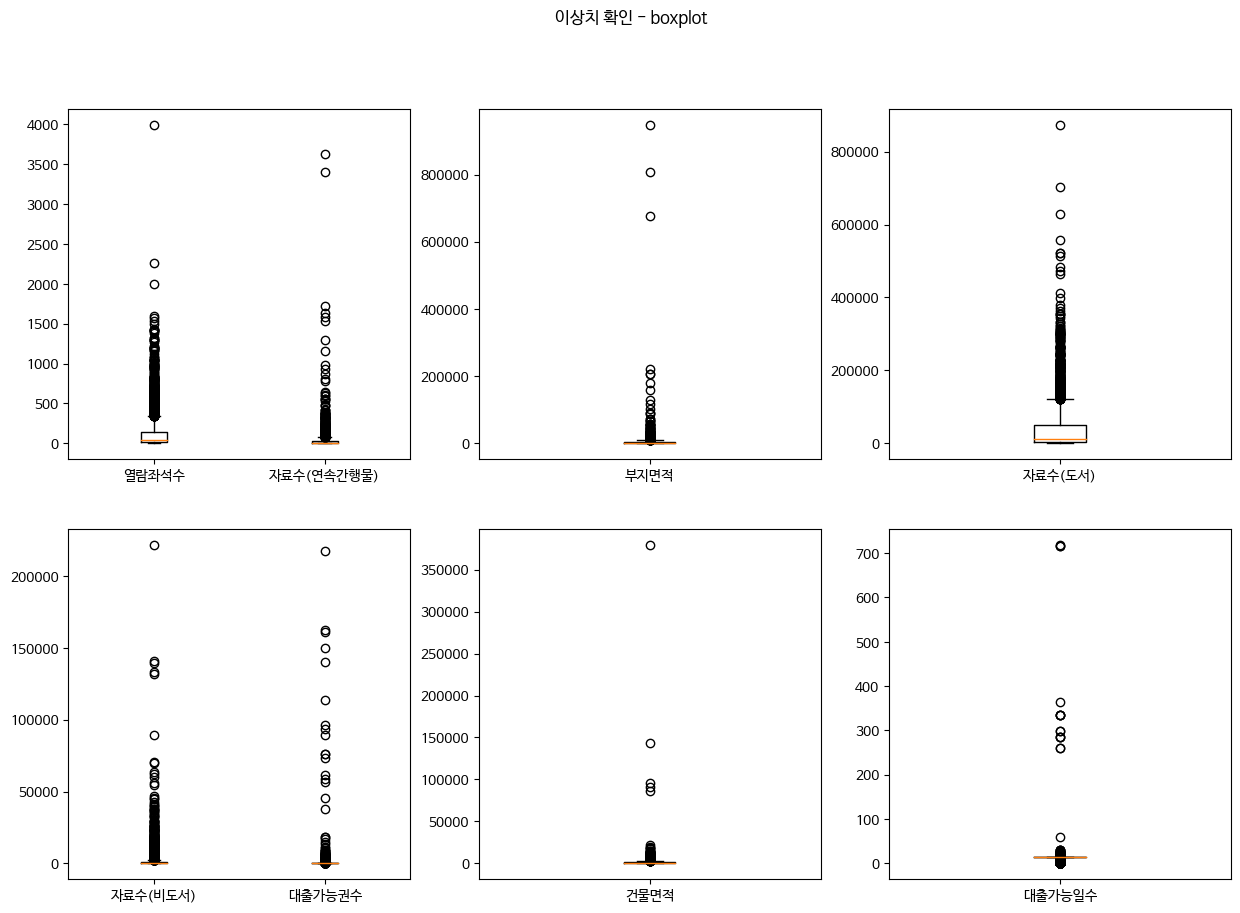

In [54]:
#box plot으로 확인
#box plot 그리기 위하여 불러옴
import matplotlib.pyplot as plt


#박스플롯으로 이상치 확인
#연속형자료만 확인
#열람좌석수, 자료수(도서), 자료수(연속간행물),자료수(비도서), 대출가능권수, 대출가능일수, 부지면적, 건물면적
# 부지면적, 건물면적은 NaN 값이 있어서 제거하고 상자그림 그래프를 그려봄


plt.figure(figsize=(15,10))

first_xlabel = ['열람좌석수', '자료수(연속간행물)']
plt.subplot(2, 3, 1)
plt.boxplot(pro_data.loc[:,first_xlabel])
plt.xticks([1,2], labels= first_xlabel)

second_xlabel = ['부지면적']
plt.subplot(2, 3, 2)
#plt.boxplot(pro_data.loc[:,['부지면적', '건물면적']])  #NaN 값이 있어서 확인이 안됨
plt.boxplot(pro_data.loc[:,second_xlabel].dropna())  #NaN 값 제거하고 일단 확인
plt.xticks([1], labels= second_xlabel)

third_xlabel = ['자료수(도서)']
plt.subplot(2, 3, 3)
plt.boxplot(pro_data.loc[:, third_xlabel])
plt.xticks([1], labels= third_xlabel)


fourth_xlabel = ['자료수(비도서)', '대출가능권수']
plt.subplot(2, 3, 4)
plt.boxplot(pro_data.loc[:, fourth_xlabel])
plt.xticks([1,2], labels= fourth_xlabel)


fifth_xlabel = ['건물면적']
plt.subplot(2, 3, 5)
plt.boxplot(pro_data.loc[:, fifth_xlabel].dropna())
plt.xticks([1], labels= fifth_xlabel)


sixth_xlabel = ['대출가능일수']
plt.subplot(2, 3, 6)
plt.boxplot(pro_data.loc[:, sixth_xlabel].dropna())
plt.xticks([1], labels= sixth_xlabel)

plt.suptitle('이상치 확인 - boxplot')

plt.show()

In [121]:
see_data = pro_data.loc[:,['도서관명', '위도','경도']]

## ====================================================

### 테스트

In [25]:
dic = {"위도" : pro_data['위도'], "경도" : data1['경도']}

In [26]:
location1 = pd.DataFrame(dic)

In [27]:
location1

,위도,경도
0,37.658160,127.299532
1,37.176854,129.335484
2,37.829691,127.506433
3,37.683315,127.491015
4,37.739591,127.424230
...,...,...
3624,NaN,NaN
3625,NaN,NaN
3626,38.125564,128.205558
3627,37.955236,128.319014


In [28]:
for i in location1:
    print(i)
    break

위도


In [78]:
# 지도 시각화를 위해 라이브러리 불러옴
import folium

#folium.Map(location=[위도, 경도])
x=37.013983
y=127.203149
m = folium.Map(location=[x, y])

In [79]:
folium.Marker([x, y]).add_to(m)
m